In [336]:
import os
import pandas as pd
import numpy as np
from scipy.stats import iqr
from statsmodels.formula.api import ols
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
# Create bar plot
plt.style.use('seaborn-v0_8-poster')
#plt.style.use('seaborn-v0_8')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})

In [346]:
project_dir = '/Users/xiaoqianxiao/projects/NARSAD'
SCR_dir = os.path.join(project_dir, 'EDR')
acquisition_file = os.path.join(SCR_dir, 'peak_stats_table-phase1.csv')
phase2and3_file = os.path.join(SCR_dir, 'peak_stats_table-phase2.3.csv')
drug_file = os.path.join(SCR_dir, 'drug_order.csv')
ECR_file = os.path.join(SCR_dir, 'ECR.csv')
df_acquisition = pd.read_csv(acquisition_file)
df_acquisition['stage'] = 'acquisition'
df_acquisition.loc[df_acquisition['stTy']=='CS+R','CS_Type'] = 'CS+_Reinf'
df_acquisition.loc[df_acquisition['stTy']=='CS+S','CS_Type'] = 'CS+_Safe'
df_acquisition.loc[df_acquisition['stTy']=='CS-','CS_Type'] = 'CS-'
print(df_acquisition.head())
df_phase2and3 = pd.read_csv(phase2and3_file)
df_phase2and3.loc[df_phase2and3['stNum']<=24,'stage'] = 'extinction'
df_phase2and3.loc[df_phase2and3['stNum']>=25,'stage'] = 'reinstatement'
df_phase2and3.loc[df_phase2and3['stTy']=='CS+R','CS_Type'] = 'CS+_Reinf'
df_phase2and3.loc[df_phase2and3['stTy']=='CS+S','CS_Type'] = 'CS+_Safe'
df_phase2and3.loc[df_phase2and3['stTy']=='CS-','CS_Type'] = 'CS-'
print(df_phase2and3.head())
df_drug = pd.read_csv(drug_file)
df_drug['group'] = df_drug['subID'].apply(lambda x: 'Patients' if x.startswith('N1') else 'Controls')
df_ECR = pd.read_csv(ECR_file)
df_behav = df_drug.merge(df_ECR, how='left', left_on='subID', right_on='subID')
df_all_acquisition = pd.merge(df_acquisition, df_behav, left_on='sid', right_on='subID', how='left')
df_all_phase2and3 = pd.merge(df_phase2and3, df_behav, left_on='sid', right_on='subID', how='left')

df_all_phases = pd.concat([df_acquisition,df_phase2and3])
merged_df = pd.merge(df_all_phases, df_behav, left_on='sid', right_on='subID', how='left')
#get no responder as reject trials
df_all = merged_df.copy()
# Assign trial numbers
df_all['trial_number'] = df_all.groupby(['stage','sid', 'CS_Type'], observed=False).cumcount().clip(upper=7) + 1
rejTrials = df_all[(df_all['phaBase2Peak'] < 0.02) | (df_all['phaBase2Peak'] > 5)].index
#df_all.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0
df_all['rejTrials'] = 0
df_all.loc[rejTrials, 'rejTrials'] = 1
df_all = df_all[df_all['Gender'].isin(['Female', 'Male'])].reset_index(drop=True)
#df_no_1st = df_all.loc[df_all['trial_number']==1].copy()
#df_all.loc[df_all['rejTrials']==1, 'phaBase2Peak'] = 0
#zscore
# df_all['z_phaBase2Peak'] = 1 + zscore(df_all['phaBase2Peak'])
# df_all_acquisition['z_phaBase2Peak'] = 1 + zscore(df_all_acquisition['phaBase2Peak'])
# df_all_phase2and3['z_phaBase2Peak'] = 1 + zscore(df_all_phase2and3['phaBase2Peak'])
#df_positive = df_no_1st.loc[df_no_1st['phaBase2Peak'] > 0].copy()
#df_positive['z_phaBase2Peak'] = 1 + zscore(df_positive['phaBase2Peak'])
#df_responder = df_all.loc[df_all['rejTrials']==0].copy()
#df_responder['z_phaBase2Peak'] = 1 + zscore(df_responder['phaBase2Peak'])

    sid  stTy  stNum  bTime  tonBase  phaBase  phaMax  phaBase2Peak  \
0  N101  CS+R      1  710.1    0.429   -0.048  -0.030         0.019   
1  N101  CS+S      2  729.1    0.776   -0.069  -0.016         0.052   
2  N101   CS-      3  749.2    0.875   -0.005   0.001         0.006   
3  N101  CS+R      4  767.2    0.738   -0.020  -0.019         0.001   
4  N101  CS+S      5  786.2    0.881   -0.171  -0.007         0.164   

   phaPeakLatency  phaMinLatency  USPeakLatency  phaMaxUS  USminLatency  \
0           712.2          710.2          720.5  0.218286         717.5   
1           734.4          732.2          739.3  0.115014         736.5   
2           753.8          749.7          760.2  0.000766         757.3   
3           769.8          769.2          777.3  0.081659         774.5   
4           791.7          789.6          796.1  0.256895         793.4   

   phaMinUS  USbase2peak  bad        stage    CS_Type  
0 -0.194254        0.413    0  acquisition  CS+_Reinf  
1 -0.06618

In [347]:
nonresponse_ratio = df_all.groupby('sid')['rejTrials'].mean()
high_nonresponse_sids = nonresponse_ratio[nonresponse_ratio > 0.9].index.tolist()
print("Subjects with non-response ratio > 0.9:", high_nonresponse_sids)

Subjects with non-response ratio > 0.9: ['N102', 'N204', 'N207']


In [348]:
df_filtered = df_all[~df_all['sid'].isin(high_nonresponse_sids)]
df_positive = df_filtered.loc[df_filtered['phaBase2Peak'] >= 0].copy()
df_positive['z_phaBase2Peak'] = 1 + zscore(df_positive['phaBase2Peak'])

In [294]:
df_filtered['sid'].unique()

array(['N101', 'N103', 'N104', 'N105', 'N106', 'N108', 'N109', 'N110',
       'N111', 'N112', 'N113', 'N114', 'N115', 'N117', 'N118', 'N121',
       'N122', 'N123', 'N124', 'N125', 'N127', 'N128', 'N129', 'N130',
       'N131', 'N132', 'N133', 'N134', 'N135', 'N136', 'N137', 'N138',
       'N141', 'N142', 'N143', 'N144', 'N145', 'N146', 'N147', 'N148',
       'N149', 'N150', 'N151', 'N153', 'N154', 'N155', 'N156', 'N157',
       'N158', 'N201', 'N202', 'N203', 'N206', 'N208', 'N209', 'N210',
       'N211', 'N212', 'N213', 'N214', 'N215', 'N216', 'N217', 'N219',
       'N220', 'N221', 'N222', 'N224', 'N225', 'N226', 'N227', 'N228',
       'N230', 'N231', 'N232', 'N233', 'N234', 'N235', 'N236', 'N237',
       'N238', 'N240', 'N241', 'N242', 'N243', 'N244', 'N246', 'N247',
       'N248', 'N249', 'N250', 'N251', 'N252', 'N253', 'N254', 'N255',
       'N257', 'N258', 'N259', 'N260'], dtype=object)

In [296]:
## Functions for outliers
# Function to detect outliers using IQR (Tukey's Fences)
def count_outliers_iqr(series, k=3):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr_val = q3 - q1
    lower_bound = q1 - k * iqr_val
    upper_bound = q3 + k * iqr_val
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers  # Return boolean Series
# Function to detect outliers using Modified Z-Score (MAD)
def count_outliers_mad(series, threshold=4):
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:
        print(f"Warning: MAD is zero for this series, falling back to IQR (k=3)")
        return count_outliers_iqr(series, k=3)
    z_m = 0.6745 * (series - median) / mad
    outliers = abs(z_m) > threshold
    return outliers  # Return boolean Series

In [298]:
## label outliers for df_all
stages = ['acquisition', 'extinction', 'reinstatement']

## Get all unique group-stage combinations
#groups = ['Patients', 'Controls']
#group_stage_pairs = [(group, stage) for group in groups for stage in stages]

# Initialize two outlier flag columns in df_responder
df_positive['outlier_flag_IQR'] = None  # Flag for IQR outliers
df_positive['outlier_flag_MAD'] = None  # Flag for MAD outliers
df_responder['outlier_flag_IQR'] = None  # Flag for IQR outliers
df_responder['outlier_flag_MAD'] = None  # Flag for MAD outliers

df = df_positive.copy()

# Initialize a list to store outlier information (for CSV export)
outlier_info = []

# Iterate over each group-stage combination to flag outliers
#for group, stage in group_stage_pairs:
    # Filter data for the current group and stage (case-insensitive for stage)
    #subset_data = df_all[(df_all['group'] == group) & 
                              #(df_all['stage'].str.lower() == stage.lower())]
for stage in stages:
    subset_data = df[(df['stage'].str.lower() == stage.lower())]
    
    # Diagnostic: Check data availability and sample
    #print(f"\nChecking data for {stage.capitalize()} - {group}:")
    print(f"\nChecking data for {stage.capitalize()}:")
    print(f"  Total rows: {len(subset_data)}")
    print(f"  phaBase2Peak NaN count: {subset_data['phaBase2Peak'].isna().sum()}")
    print(f"  phaBase2Peak non-NaN count: {subset_data['phaBase2Peak'].count()}")
    print(f"  Sample of phaBase2Peak values: {subset_data['phaBase2Peak'].head().tolist()}")
    print(f"  Full phaBase2Peak description:\n{subset_data['phaBase2Peak'].describe()}")

    # Compute descriptive statistics
    group_data = subset_data['phaBase2Peak']
    if group_data.empty or group_data.isna().all():
        print(f"Descriptive Statistics for {stage.capitalize()}: No data")
        continue
    stats = {
        'N': group_data.count(),           # Number of non-NaN observations
        'Min': group_data.min(),
        'Max': group_data.max(),
        'Mean': group_data.mean(),
        'Median': group_data.median(),
        'IQR': iqr(group_data),
        'Outliers_IQR': count_outliers_iqr(group_data, k=3).sum(),  # Count of IQR outliers
        'Outliers_MAD': count_outliers_mad(group_data, threshold=4).sum(),  # Count of MAD outliers
        'NaN Count': group_data.isna().sum()
    }
    
    # Detect outliers and flag them in df_responder
    outliers_iqr = count_outliers_iqr(group_data, k=3)
    outliers_mad = count_outliers_mad(group_data, threshold=4)
    
    print(f"  IQR outliers count (k=3): {outliers_iqr.sum()}")
    print(f"  MAD outliers count (threshold=4): {outliers_mad.sum()}")

    # Flag outliers in df_responder
    #mask = (df_all['group'] == group) & (df_all['stage'].str.lower() == stage.lower())
    mask = df['stage'].str.lower() == stage.lower()
    df.loc[mask & outliers_iqr, 'outlier_flag_IQR'] = 'Outlier'
    df.loc[mask & ~outliers_iqr, 'outlier_flag_IQR'] = None  # Explicitly set non-outliers to None
    df.loc[mask & outliers_mad, 'outlier_flag_MAD'] = 'Outlier'
    df.loc[mask & ~outliers_mad, 'outlier_flag_MAD'] = None  # Explicitly set non-outliers to None
df_cleaned = df.loc[df['outlier_flag_IQR'] != 'Outlier'].copy()
#df_cleaned['z_phaBase2Peak'] = 1 + zscore(df_cleaned['phaBase2Peak'])


Checking data for Acquisition:
  Total rows: 1809
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 1809
  Sample of phaBase2Peak values: [0.019, 0.052, 0.006, 0.001, 0.164]
  Full phaBase2Peak description:
count    1809.000000
mean        0.077924
std         0.149260
min         0.001000
25%         0.003000
50%         0.017000
75%         0.083000
max         1.803000
Name: phaBase2Peak, dtype: float64
  IQR outliers count (k=3): 106
  MAD outliers count (threshold=4): 378

Checking data for Extinction:
  Total rows: 2349
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 2349
  Sample of phaBase2Peak values: [0.023, 0.037, 0.02, 0.015, 0.103]
  Full phaBase2Peak description:
count    2349.000000
mean        0.038693
std         0.105049
min         0.001000
25%         0.017000
50%         0.022000
75%         0.029000
max         3.808000
Name: phaBase2Peak, dtype: float64
  IQR outliers count (k=3): 187
  MAD outliers count (threshold=4): 257

Checking data for R

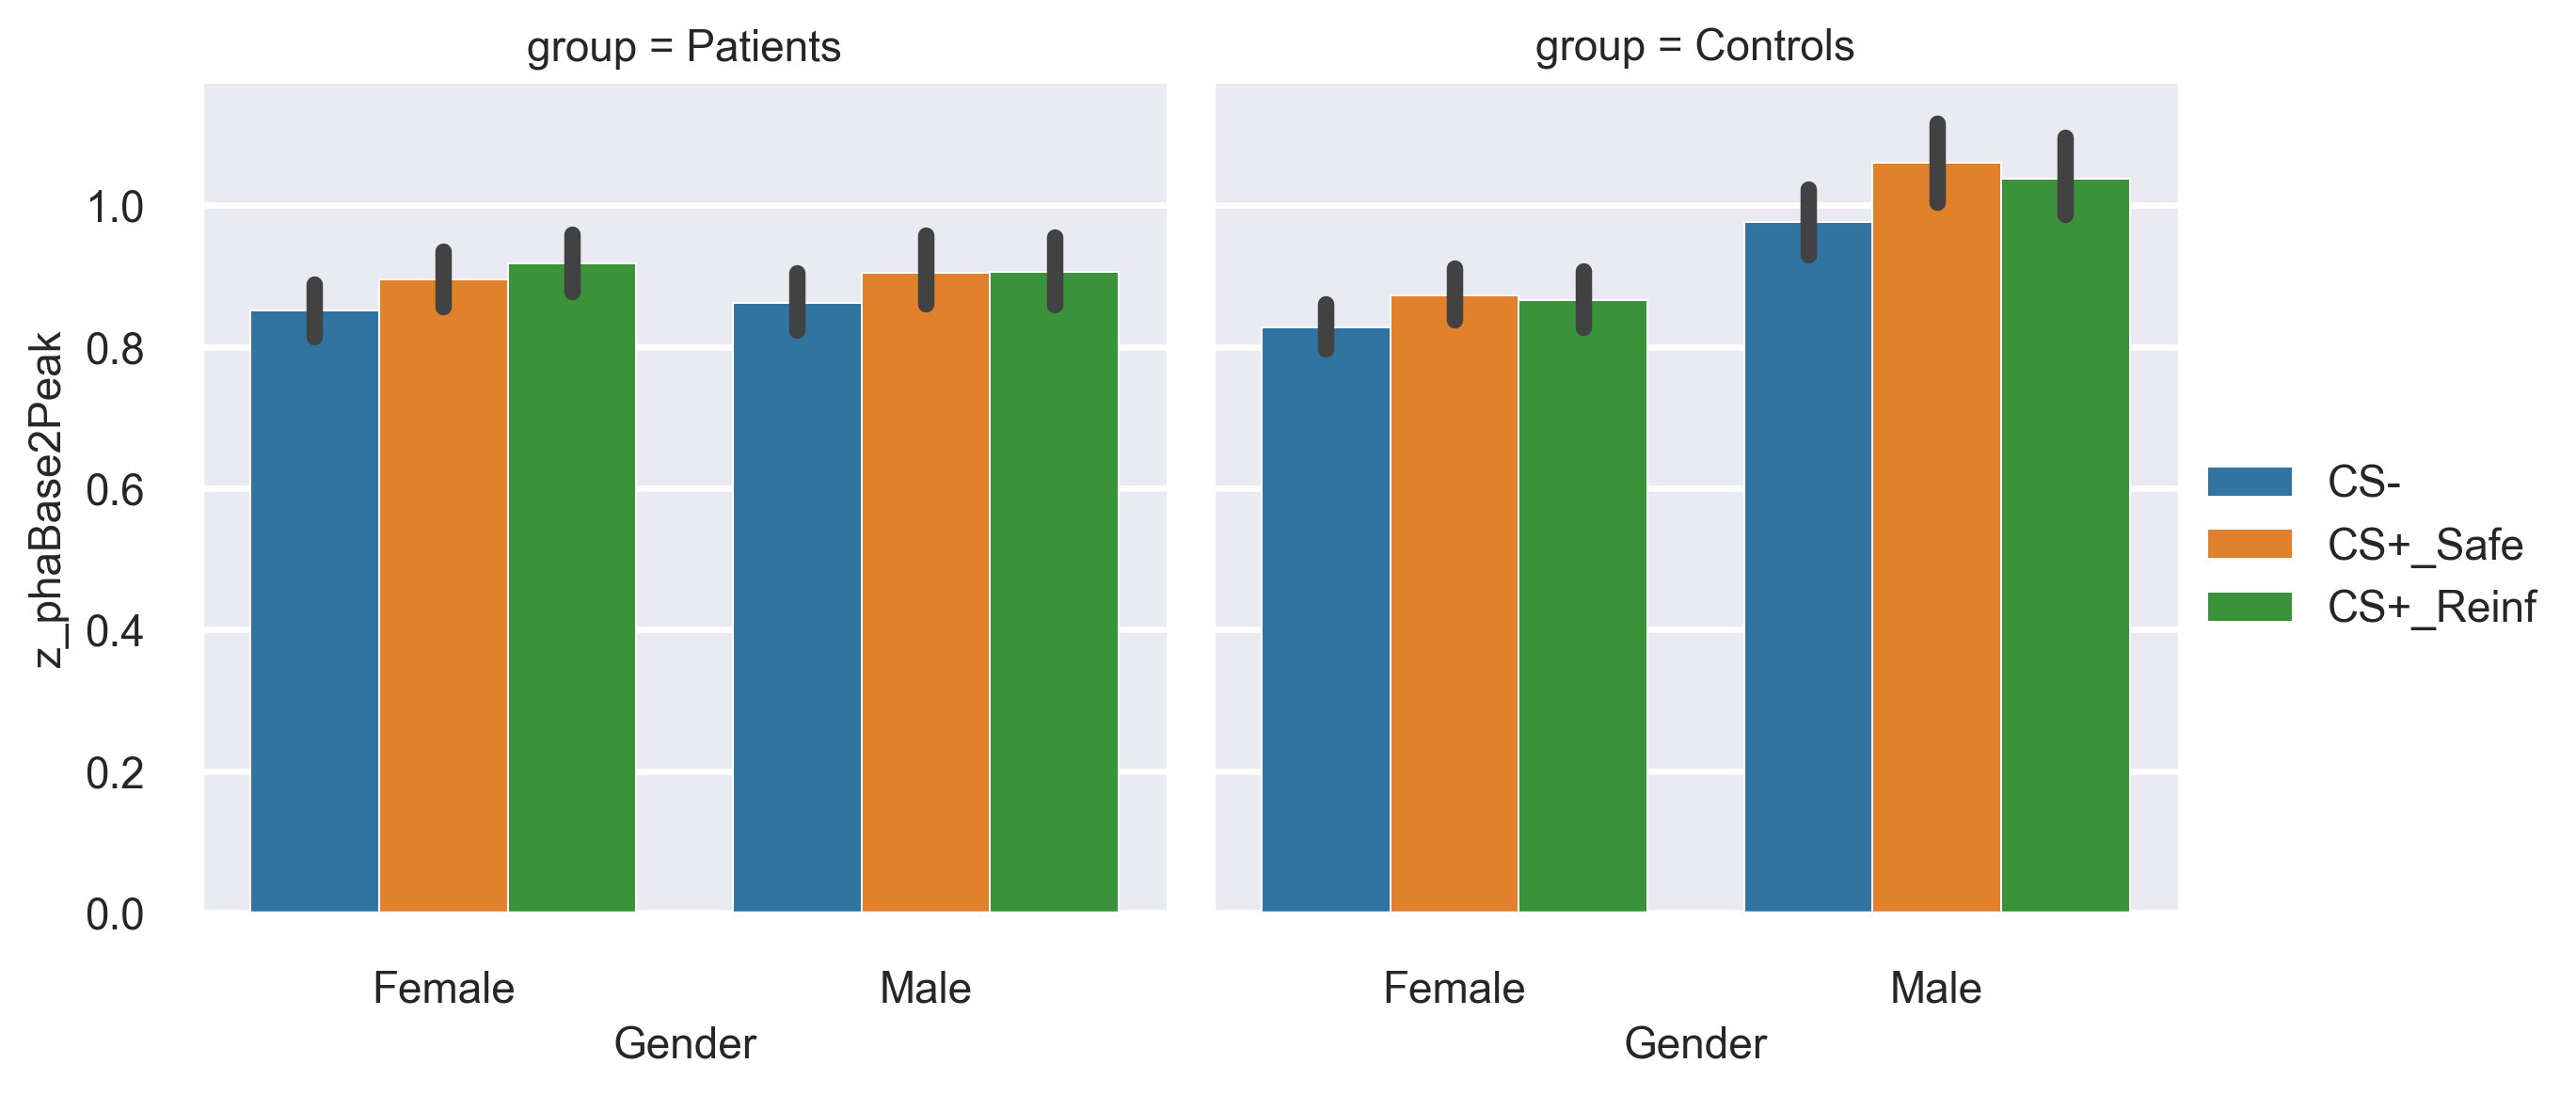

In [349]:
from scipy.stats import mstats
# Winsorize z_phaBase2Peak at 5th and 95th percentiles
df_Winsorize_z = df_positive.copy()
df_Winsorize_z['z_phaBase2Peak'] = df_Winsorize_z.groupby('stage')['z_phaBase2Peak'].transform(
    lambda x: mstats.winsorize(x, limits=[0.05, 0.05])
)
g = sns.catplot(x='Gender', y='z_phaBase2Peak', hue='CS_Type', col='group', kind='bar', 
                height=4, aspect=1, 
                hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
                data=df_Winsorize_z)
g.legend.set_title("")
g.figure.set_dpi(300)

In [354]:
df = df_positive
df_positive = df[abs(df['z_phaBase2Peak']) <= 3].copy()

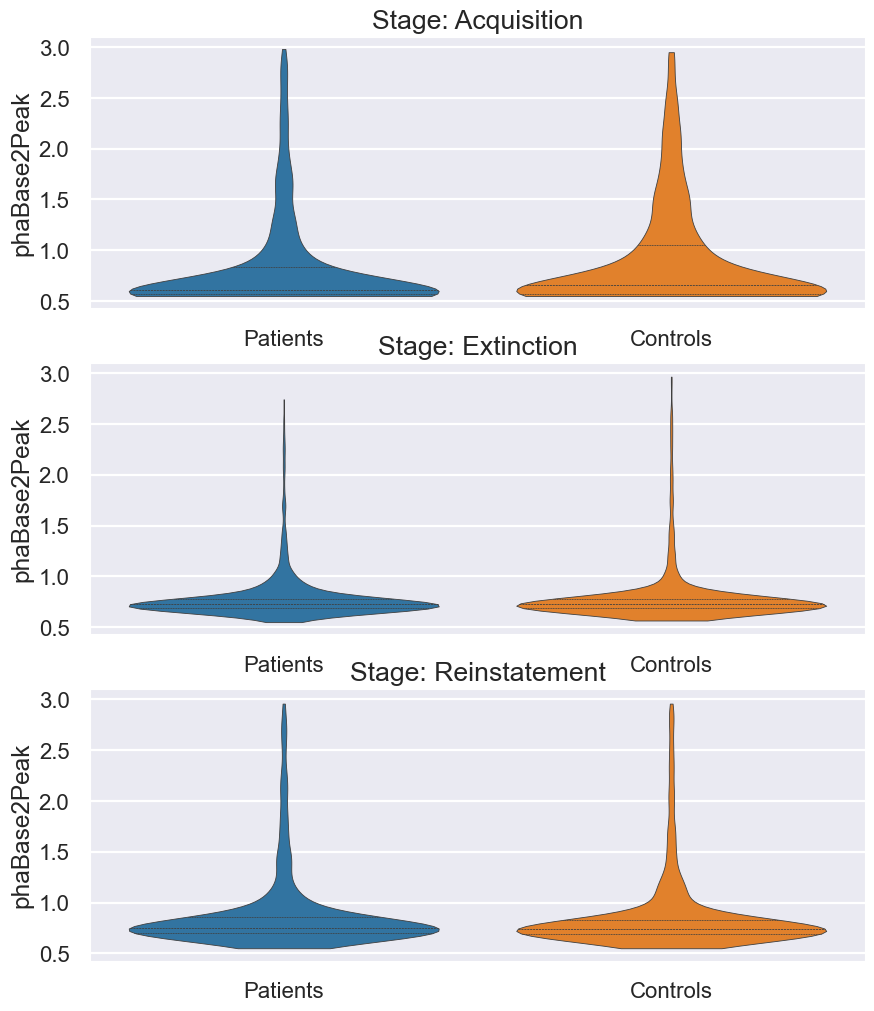

In [355]:
df = df_positive.copy()
stages = ['acquisition', 'extinction', 'reinstatement']
groups = ['Patients', 'Controls']  # Match your data’s group names

# Create subplots: one row per stage
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharey=True)

# Iterate over stages and create violin plots
for i, stage in enumerate(stages):
    # Filter data for the current stage
    stage_data = df[df['stage'].str.lower() == stage.lower()]
    
    # Create violin plot
    sns.violinplot(
        data=stage_data,
        x='group',  # Groups on x-axis
        y='z_phaBase2Peak',
        hue='group',  # Color by group
        split=False,  # Full violins (not split)
        inner='quartile',  # Show quartiles inside violins
        cut=0,
        ax=axes[i]
    )
    
    # Customize the subplot
    # Set y-axis limit to 0, 1
    #axes[i].set_ylim(0, 1)
    axes[i].set_title(f'Stage: {stage.capitalize()}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('phaBase2Peak')  # Center y-label

In [251]:
df.columns

Index(['sid', 'stTy', 'stNum', 'bTime', 'tonBase', 'phaBase', 'phaMax',
       'phaBase2Peak', 'phaPeakLatency', 'phaMinLatency', 'USPeakLatency',
       'phaMaxUS', 'USminLatency', 'phaMinUS', 'USbase2peak', 'bad', 'stage',
       'CS_Type', 'subID', 'Drug', 'drug_condition', 'Gender', 'gender_code',
       'group', 'ecr_q1', 'ecr_q2', 'ecr_q3', 'ecr_q4', 'ecr_q5', 'ecr_q6',
       'ecr_q7', 'ecr_q8', 'ecr_q9', 'ecr_q10', 'ecr_q11', 'ecr_q12',
       'ecr_q13', 'ecr_q14', 'ecr_q15', 'ecr_q16', 'ecr_q17', 'ecr_q18',
       'ecr_q19', 'ecr_q20', 'ecr_q21', 'ecr_q22', 'ecr_q23', 'ecr_q24',
       'ecr_q25', 'ecr_q26', 'ecr_q27', 'ecr_q28', 'ecr_q29', 'ecr_q30',
       'ecr_q31', 'ecr_q32', 'ecr_q33', 'ecr_q34', 'ecr_q35', 'ecr_q36',
       'demo_age', 'demo_sex_at_birth', 'Anxiety', 'Avoidance', 'total_score',
       'trial_number', 'rejTrials', 'Avoidance_centered', 'CS'],
      dtype='object')

                            Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            z_phaBase2Peak
No. Observations:             1917               Method:                        REML          
No. Groups:                   100                Scale:                         0.1405        
Min. group size:              5                  Log-Likelihood:                -1005.7703    
Max. group size:              24                 Converged:                     Yes           
Mean group size:              19.2                                                            
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            0.982    0.155  6.328 0.00

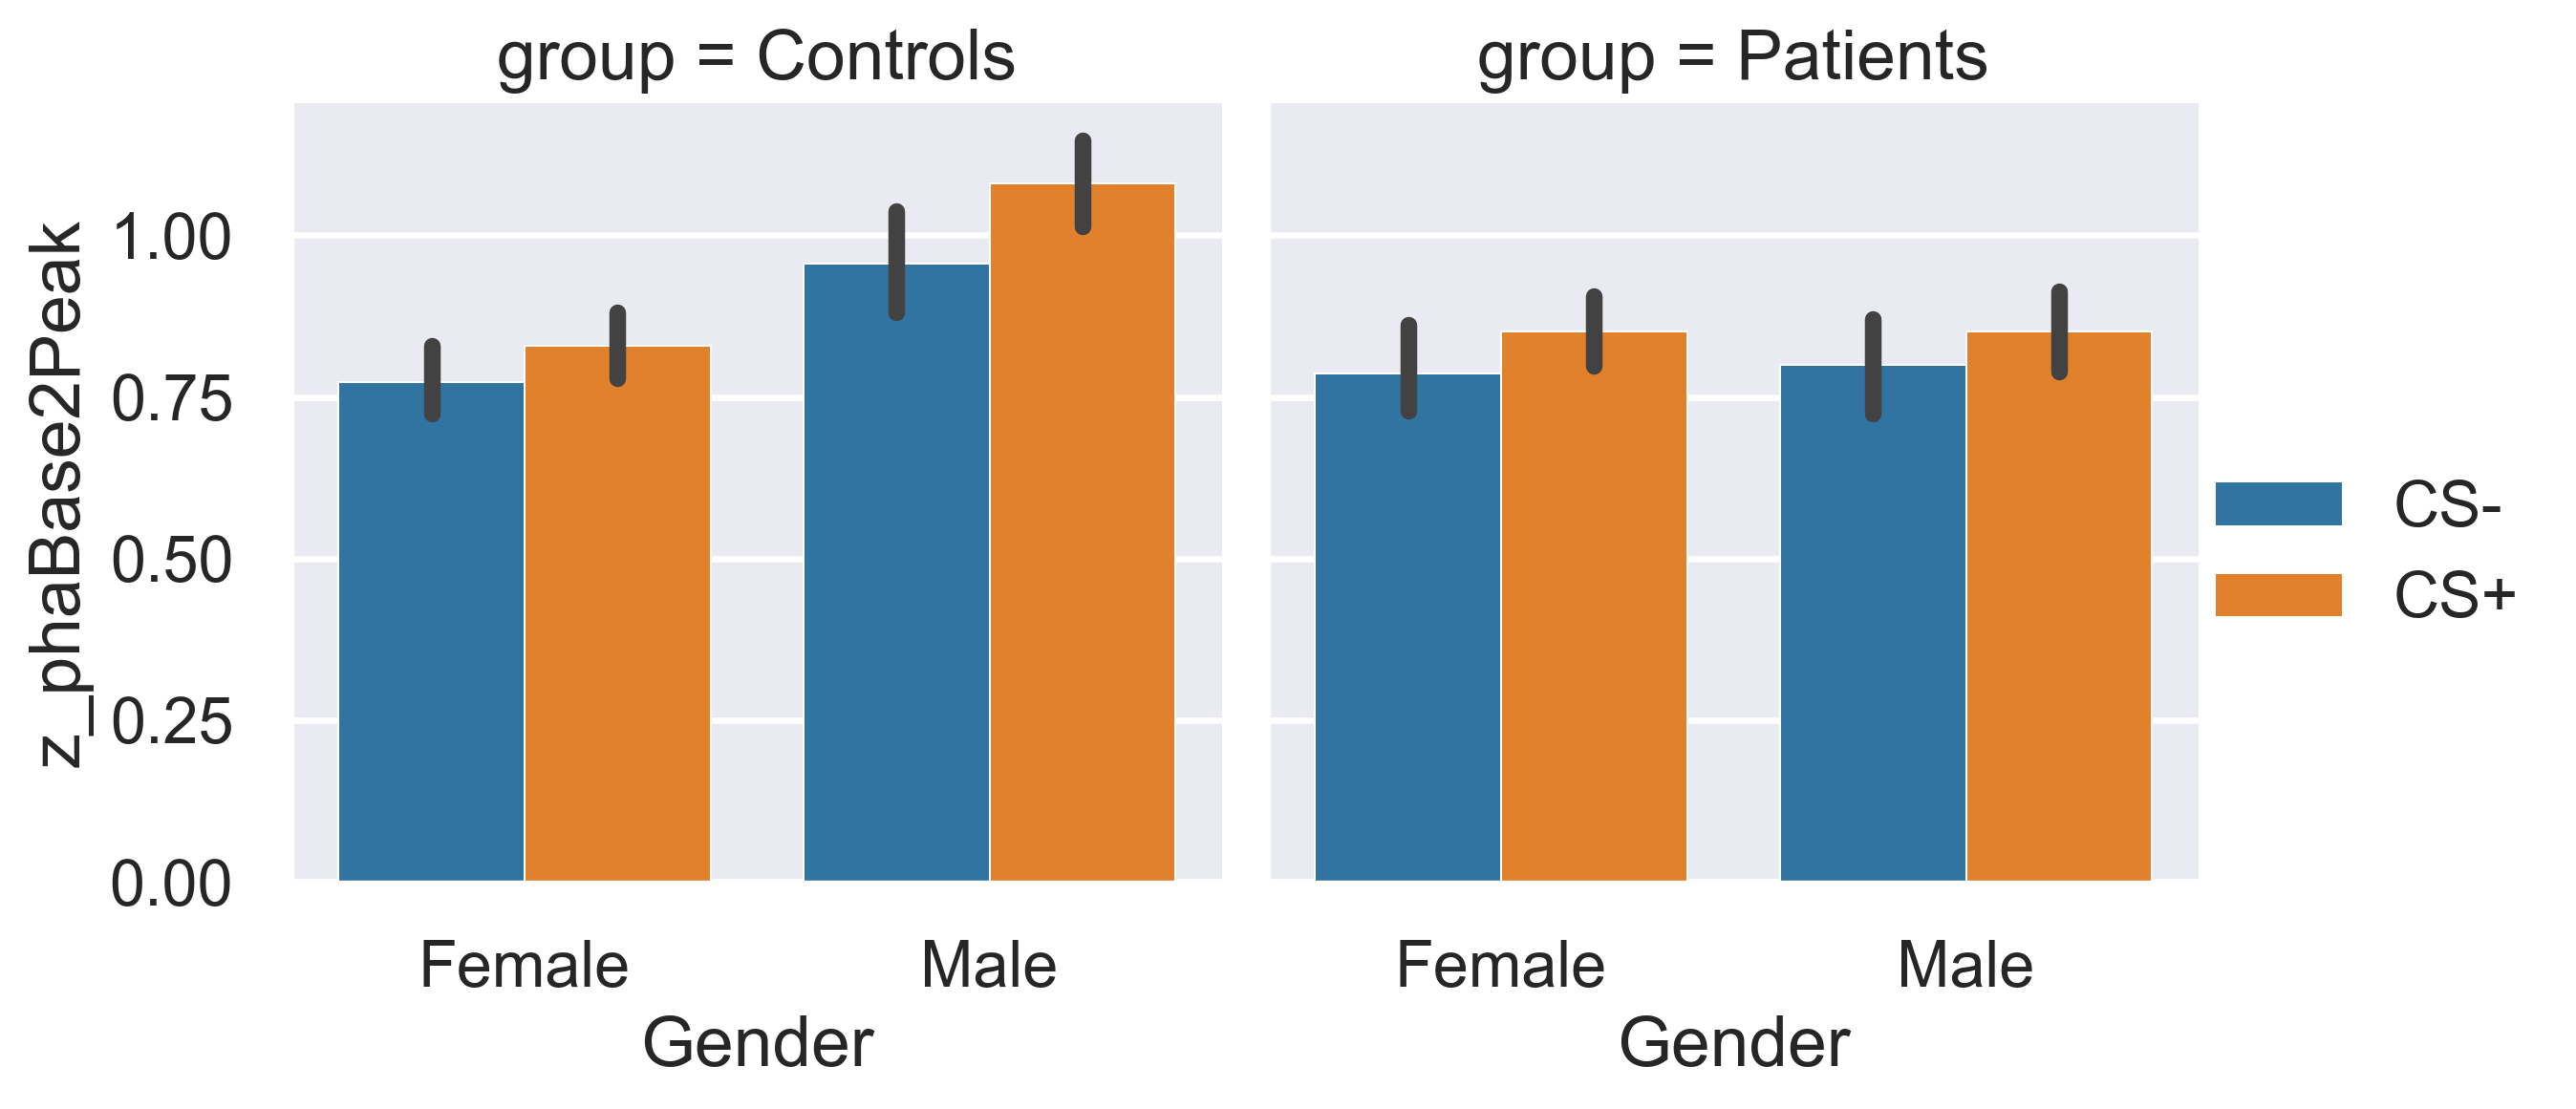

In [356]:
## acquisition
#df = df_Winsorize_z.loc[df_Winsorize_z['stage']=='acquisition'].copy()
#df = df_all.loc[(df_all['stage']=='acquisition') & (df_all['trial_number']!=1)].copy()
df = df_positive.loc[df_positive['stage']=='acquisition'].copy()
df['Avoidance_centered'] = df['Avoidance'] - df['Avoidance'].mean()
df['CS'] = 'CS+'  # Default to 'CS+'
df.loc[df['CS_Type'] == 'CS-', 'CS'] = 'CS-'  # Modify only where CS_Type is 'CS-'

df[['group', 'CS', 'Gender']] = df[['group', 'CS', 'Gender']].astype('category')
model = smf.mixedlm(
    formula="z_phaBase2Peak ~ C(group) * C(CS) * C(Gender) + Avoidance_centered + demo_age",
    data=df,
    groups=df['sid']
)
result = model.fit()
print(result.summary())
#
#
plt.style.use('seaborn-v0_8-poster')
g = sns.catplot(x='Gender', y='z_phaBase2Peak', hue='CS', col='group', kind='bar', 
                hue_order=['CS-', 'CS+'],
                height=4, aspect=1,
                data=df)
g.legend.set_title("")
g.figure.set_dpi(300)

                                           Mixed Linear Model Regression Results
Model:                                 MixedLM                      Dependent Variable:                      z_phaBase2Peak
No. Observations:                      873                          Method:                                  REML          
No. Groups:                            99                           Scale:                                   0.0271        
Min. group size:                       6                            Log-Likelihood:                          165.0866      
Max. group size:                       9                            Converged:                               Yes           
Mean group size:                       8.8                                                                                 
---------------------------------------------------------------------------------------------------------------------------
                                                   

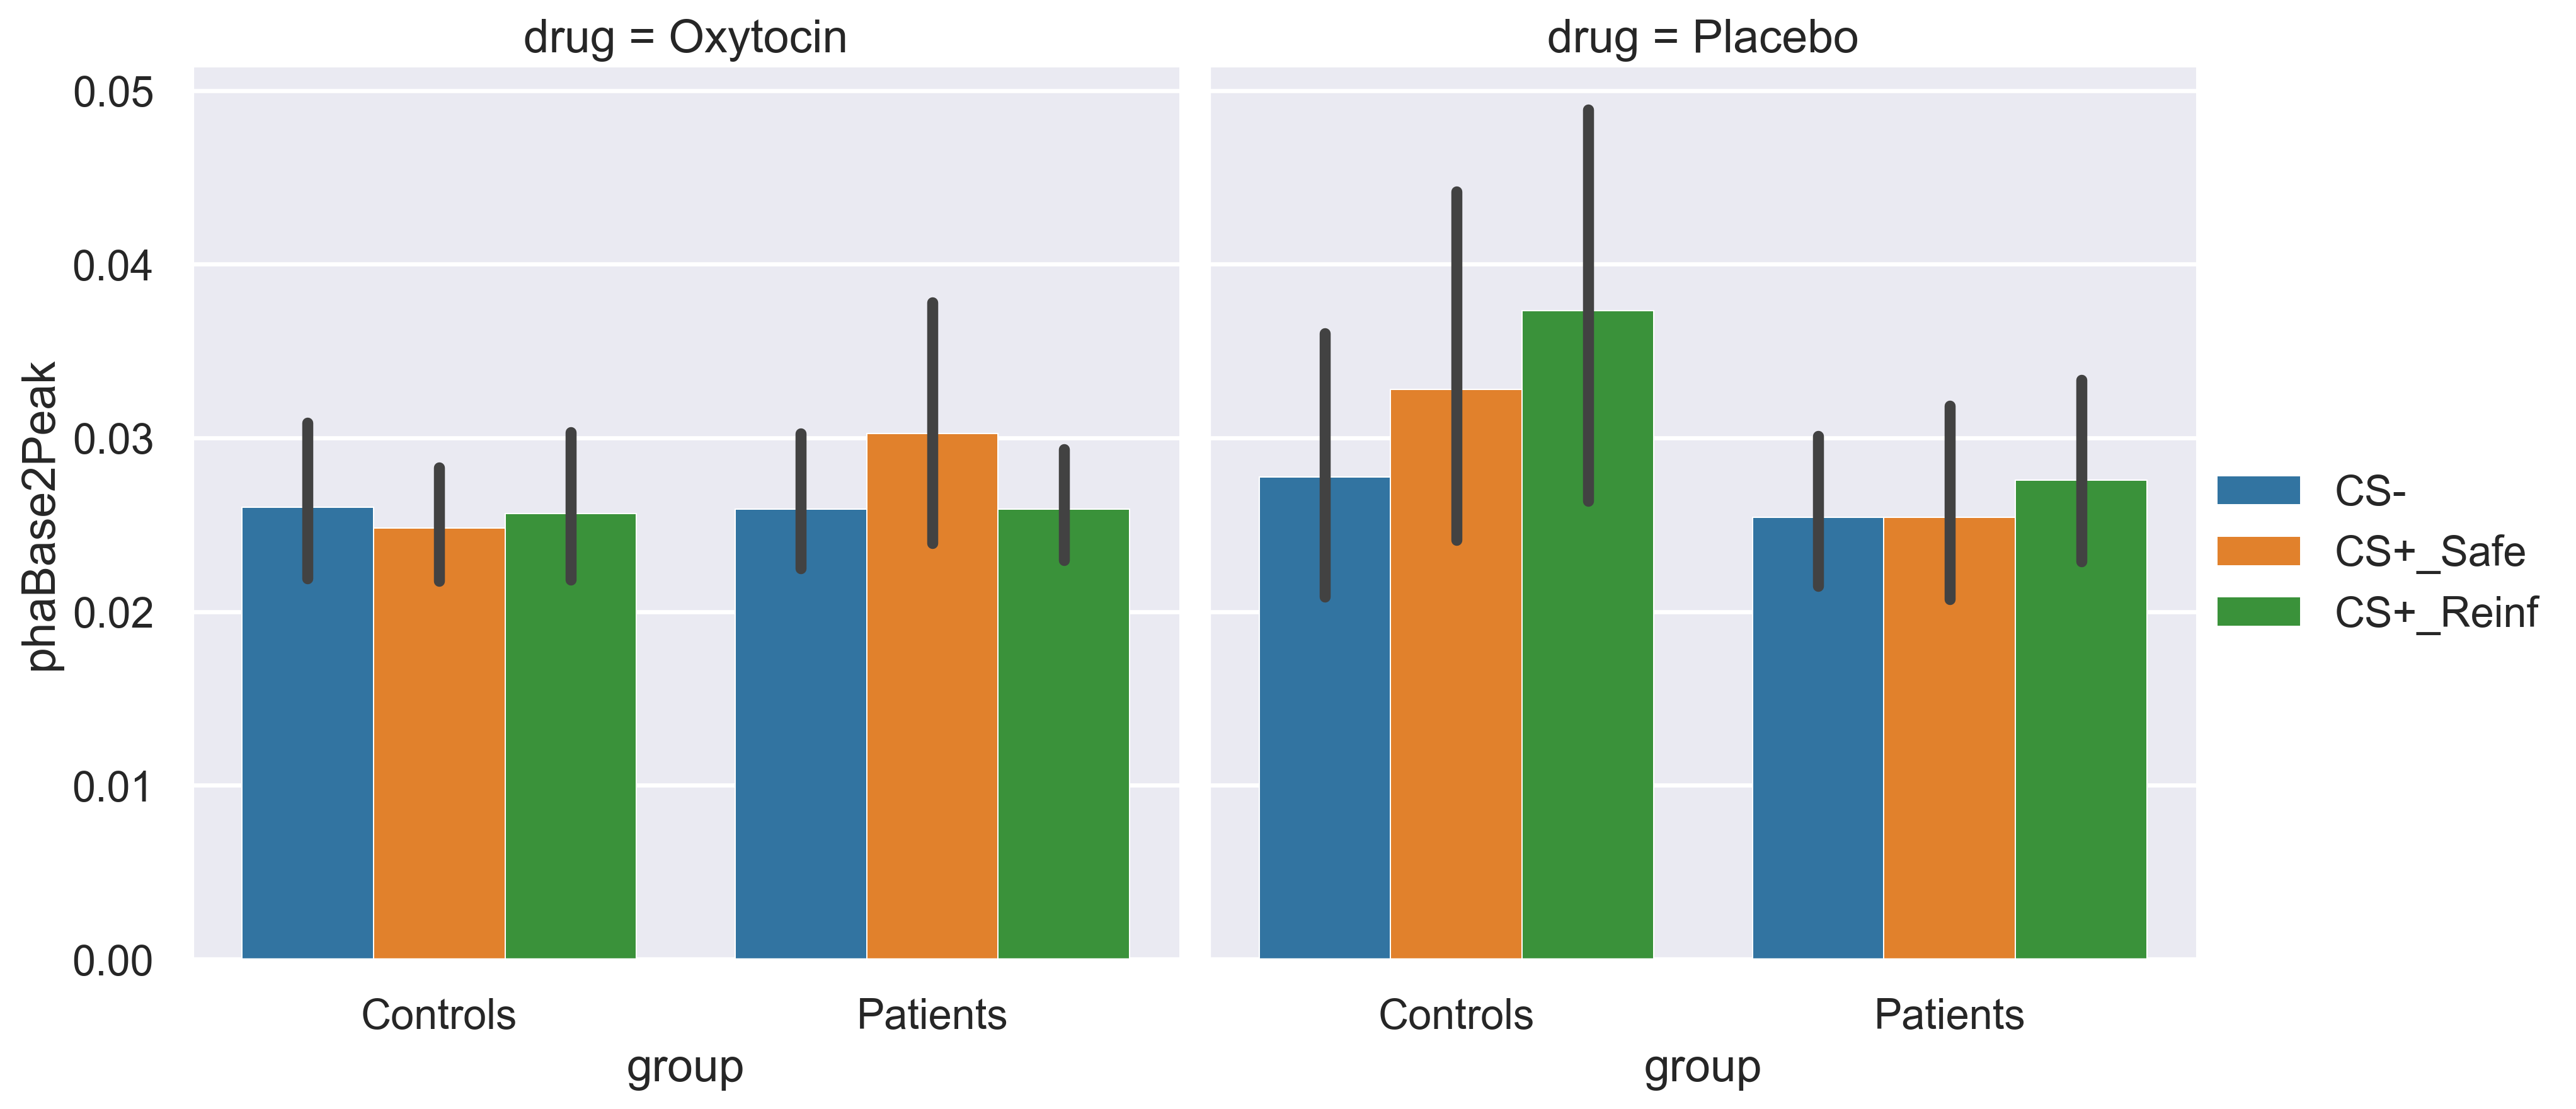

In [358]:
## extinction
df = df_positive.loc[(df_positive['stage']=='extinction') & (df_positive['trial_number']>=6)].copy()
#df = df_positive.loc[df_positive['stage']=='extinction'].copy()
#df = df_Winsorize_z.loc[df_Winsorize_z['stage']=='extinction'].copy()
df['Avoidance_centered'] = df['Avoidance'] - df['Avoidance'].mean()

df[['group', 'CS_Type', 'Gender','drug']] = df[['group', 'CS_Type', 'Gender' ,'Drug']].astype('category')
model = smf.mixedlm(
    formula="z_phaBase2Peak ~ C(group) * C(CS_Type) * C(Gender) * C(drug) + Avoidance_centered + demo_age",
    data=df,
    groups=df['sid']
)
result = model.fit()
print(result.summary())
#
plt.style.use('seaborn-v0_8-poster')
# g = sns.catplot(x='Gender', y='z_phaBase2Peak', hue='CS_Type', col='group', row='drug', kind='bar', 
#                 hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
#                 height=6, aspect=1,
#                 data=df)
g = sns.catplot(x='group', y='phaBase2Peak', hue='CS_Type', col='drug', kind='bar', 
                hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
                height=6, aspect=1,
                data=df)
g.legend.set_title("")
g.figure.set_dpi(300)

                                           Mixed Linear Model Regression Results
Model:                                 MixedLM                      Dependent Variable:                      z_phaBase2Peak
No. Observations:                      867                          Method:                                  REML          
No. Groups:                            99                           Scale:                                   0.0475        
Min. group size:                       3                            Log-Likelihood:                          -54.7899      
Max. group size:                       9                            Converged:                               Yes           
Mean group size:                       8.8                                                                                 
---------------------------------------------------------------------------------------------------------------------------
                                                   

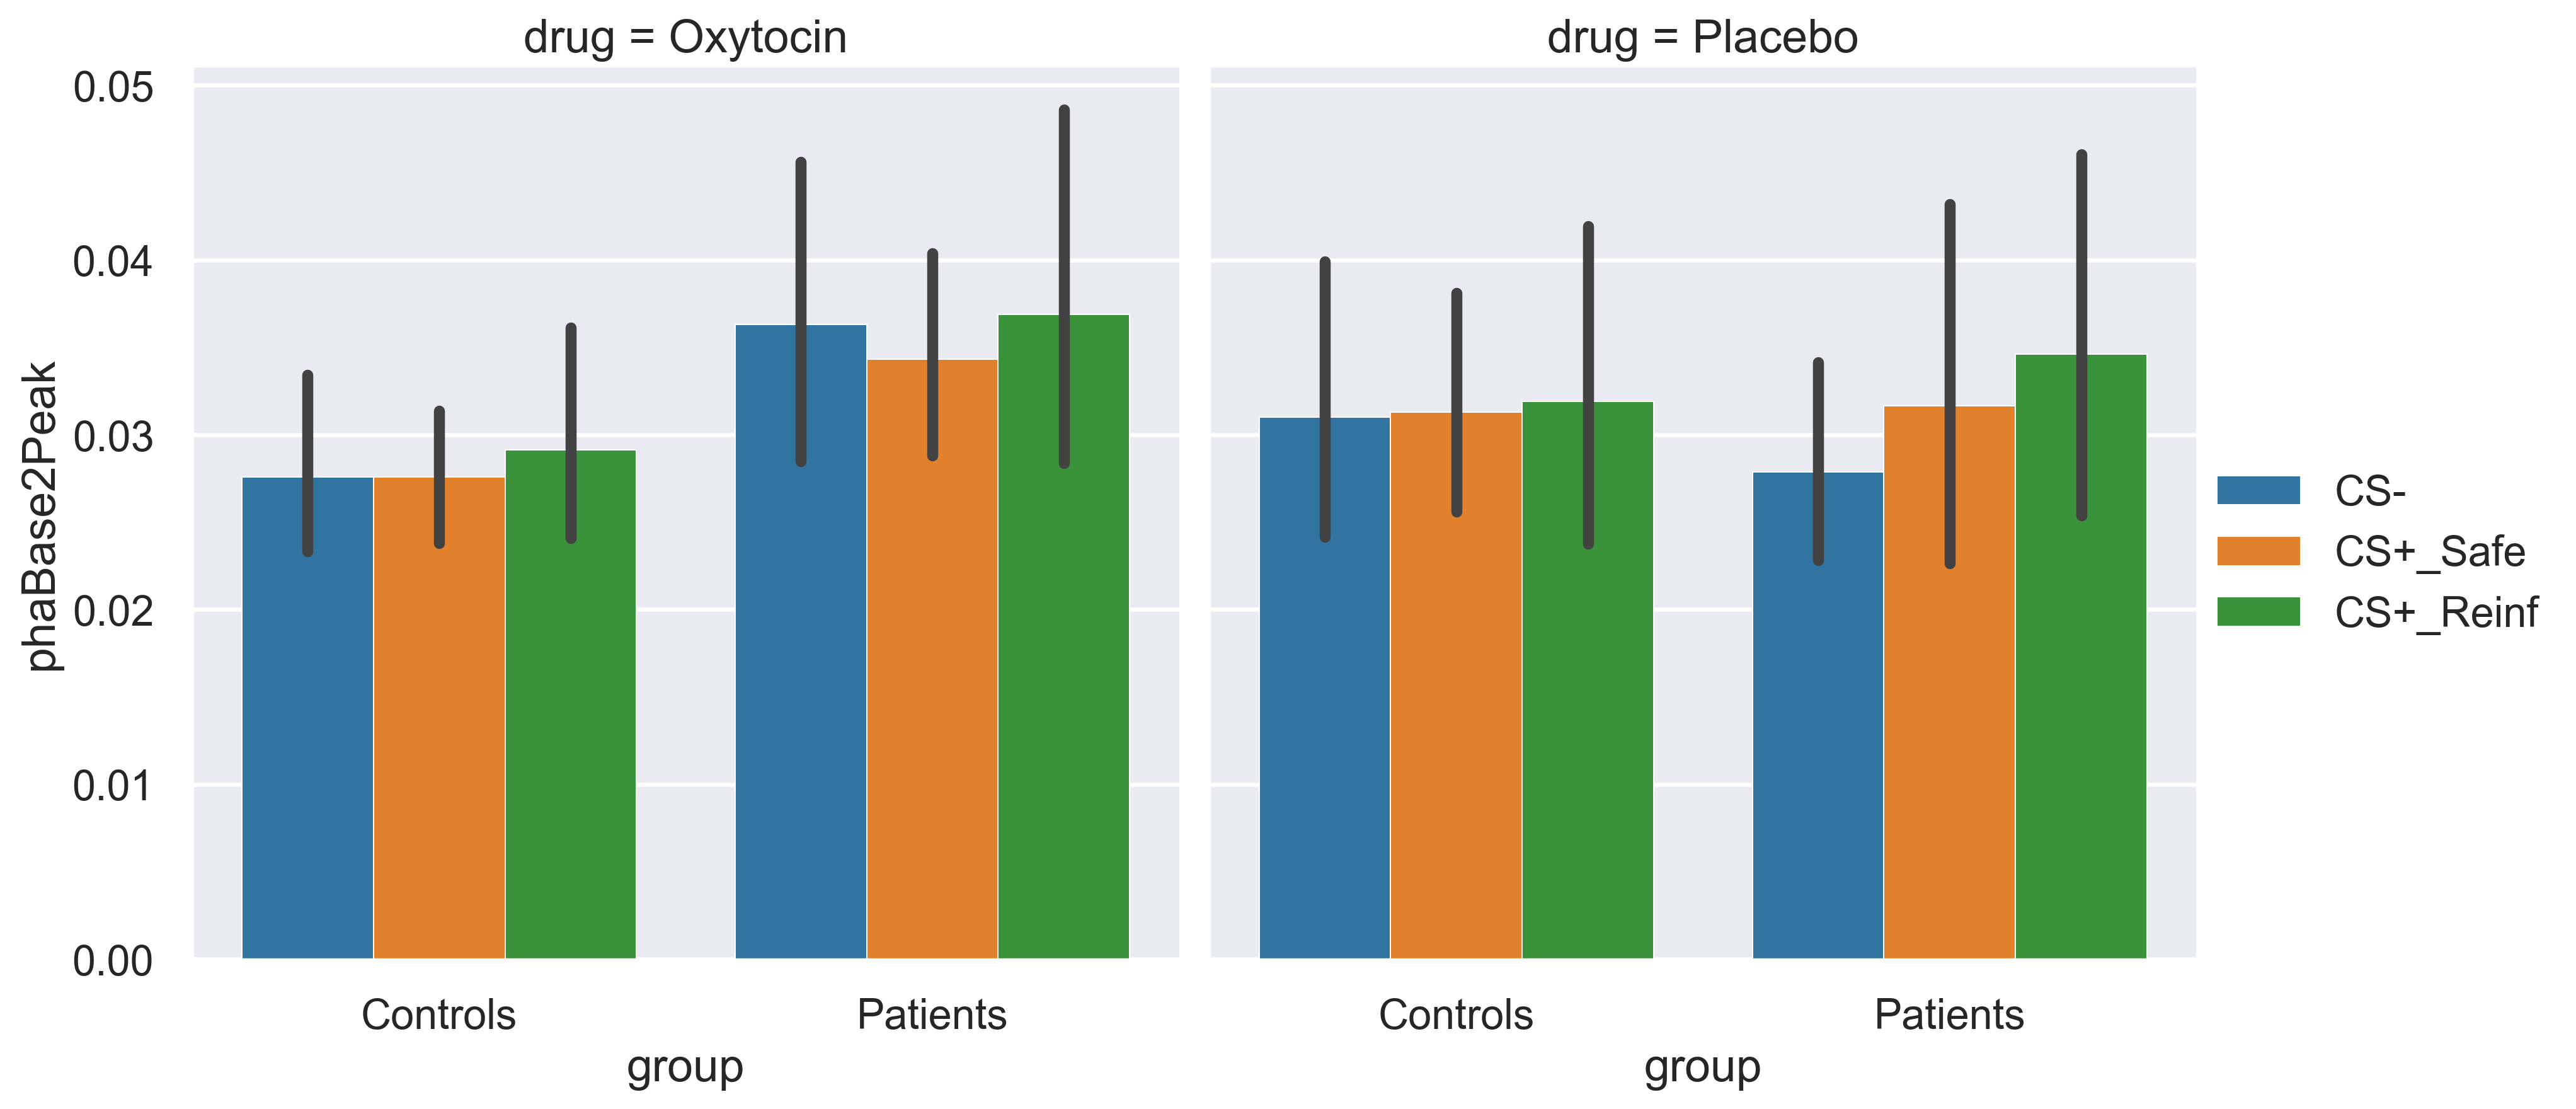

In [359]:
## reinstatement 
#noisy_sub_list = [112, 214,226,231, 241, 257, 258,]
#df = df_all.loc[(df_all['stage']=='reinstatement') & (df_all['trial_number']!=1) & (~df_all['sid'].isin(noisy_sub_list))].copy()
#df = df_positive.loc[df_positive['stage']=='reinstatement'].copy()
df = df_positive.loc[(df_positive['stage']=='reinstatement') & (df_positive['trial_number']>=6)].copy()

#df = df_Winsorize_z.loc[df_Winsorize_z['stage']=='reinstatement'].copy()
df['Avoidance_centered'] = df['Avoidance'] - df['Avoidance'].mean()
df[['group', 'CS_Type', 'Gender','drug']] = df[['group', 'CS_Type', 'Gender' ,'Drug']].astype('category')
model = smf.mixedlm(
    formula="z_phaBase2Peak ~ C(group) * C(CS_Type) * C(Gender) * C(drug) + Avoidance_centered + demo_age",
    data=df,
    groups=df['sid']
)
result = model.fit()
print(result.summary())
#
plt.style.use('seaborn-v0_8-poster')
# g = sns.catplot(x='Gender', y='z_phaBase2Peak', hue='CS_Type', col='group', row='drug', kind='bar', 
#                 hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
#                 height=6, aspect=1,
#                 data=df)
g = sns.catplot(x='group', y='phaBase2Peak', hue='CS_Type', col='drug', kind='bar', 
                hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
                height=6, aspect=1,
                data=df)
g.legend.set_title("")
g.figure.set_dpi(300)

In [180]:
df[['sid','stNum','stTy','CS_Type']]

,sid,stNum,stTy,CS_Type
2496,N101,25,CS-,CS-
2497,N101,26,CS+S,CS+_Safe
2498,N101,27,CS+R,CS+_Reinf
2499,N101,28,CS+S,CS+_Safe
2500,N101,29,CS+R,CS+_Reinf
...,...,...,...,...
7315,N260,44,CS+S,CS+_Safe
7316,N260,45,CS+R,CS+_Reinf
7317,N260,46,CS-,CS-
7318,N260,47,CS+R,CS+_Reinf


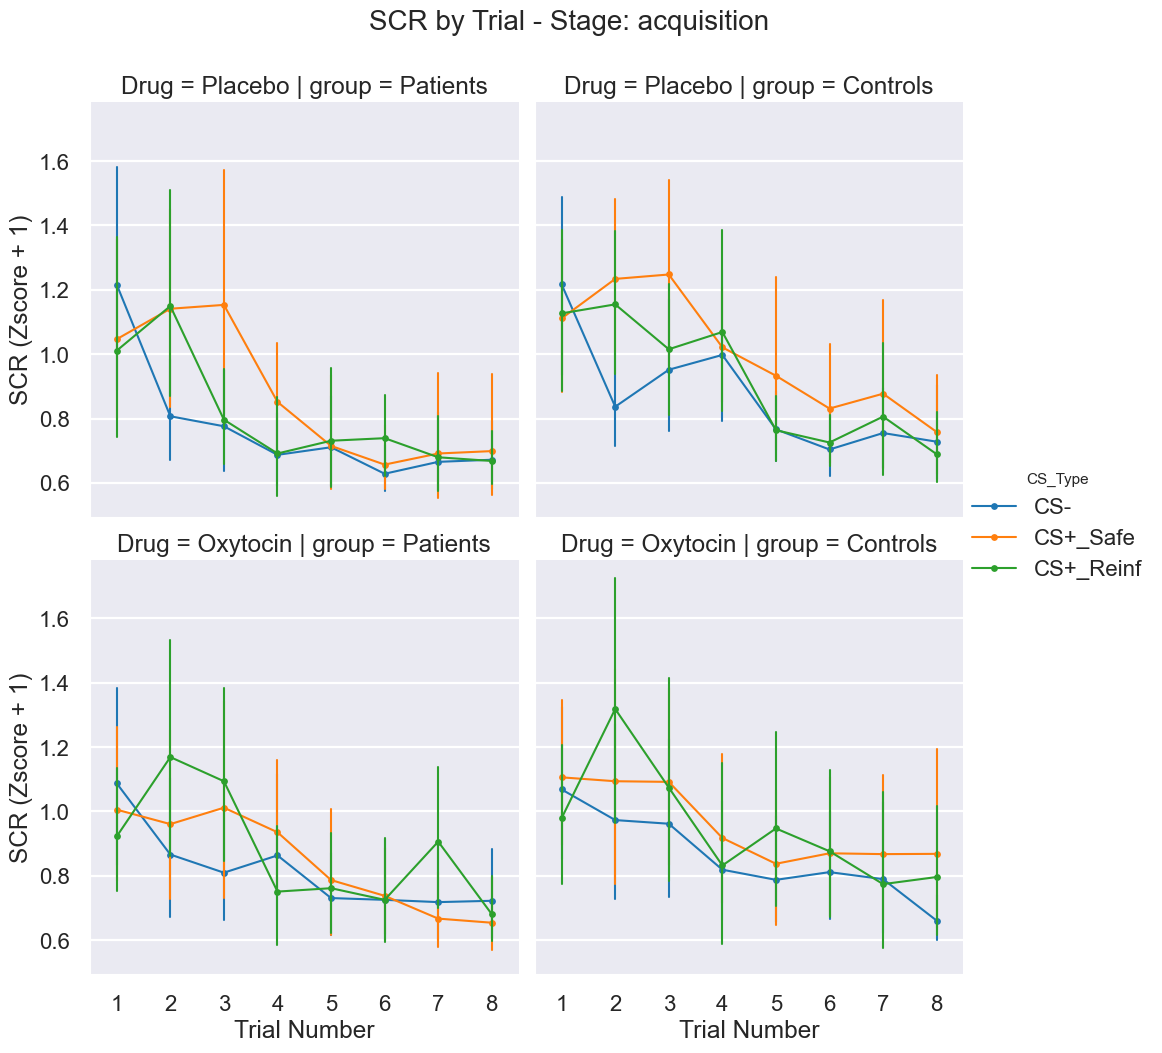

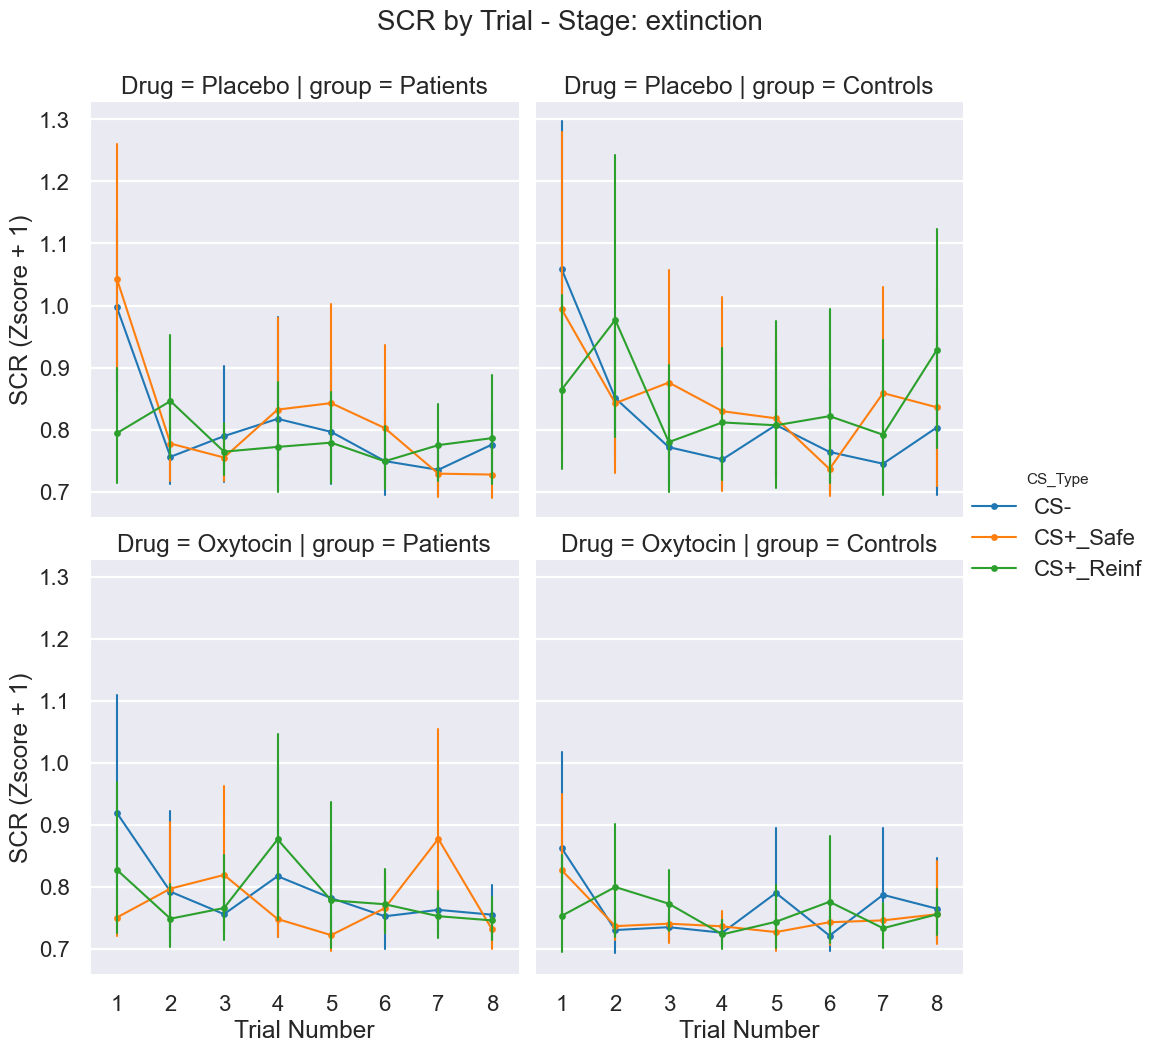

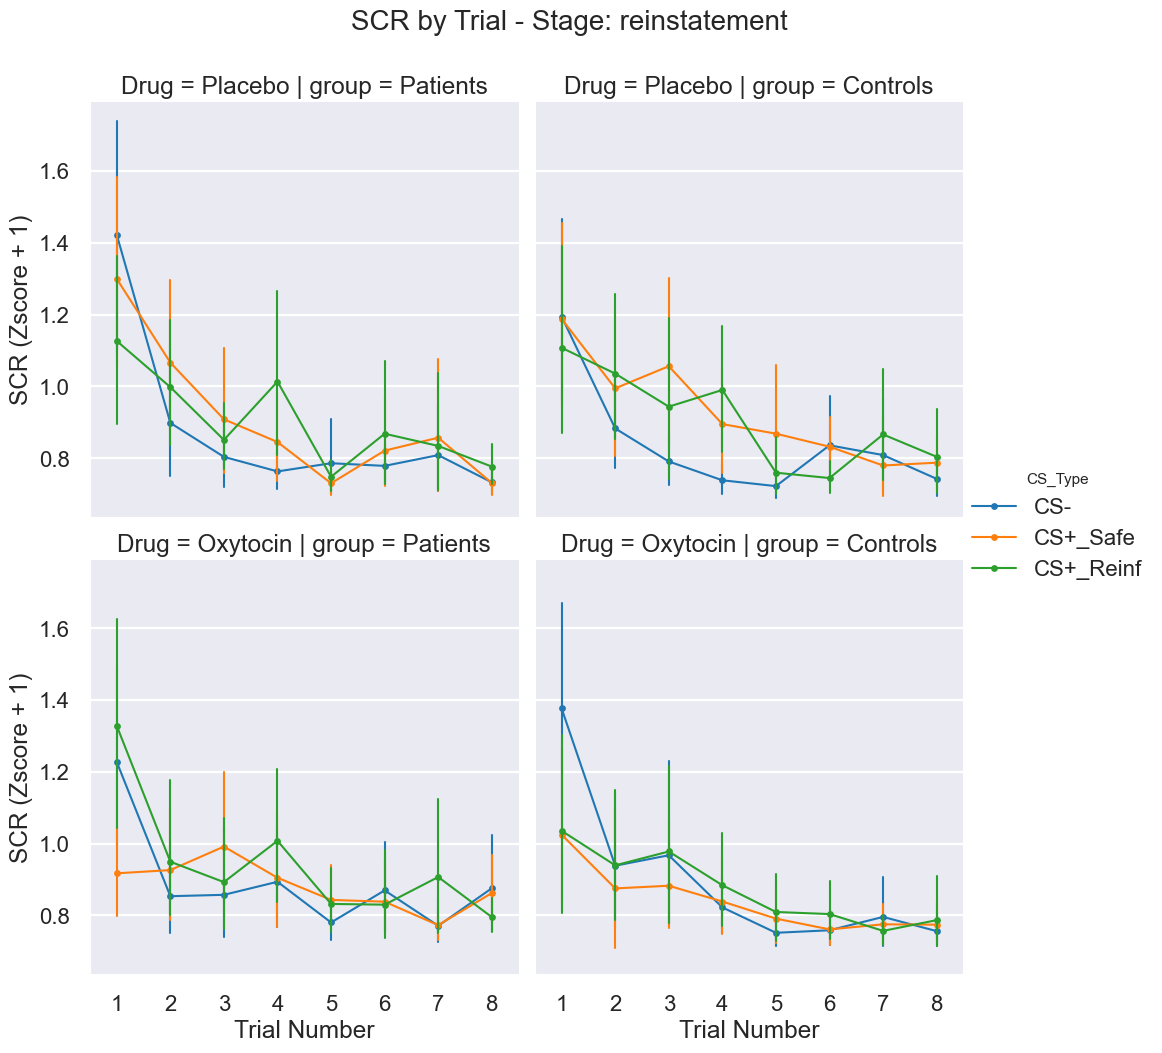

In [372]:
stages = df_positive['stage'].unique()
for stage in stages:
    df = df_positive.loc[df_positive['stage']==stage].copy()
    g = sns.catplot(x='trial_number', y='z_phaBase2Peak', hue='CS_Type', 
                    col='group', row='Drug', kind='point', 
                    hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
                    linewidth=1.5,
                    data=df)
    g.set_axis_labels(x_var='Trial Number', y_var='SCR (Zscore + 1)')
    g.fig.suptitle(f'SCR by Trial - Stage: {stage}', y=1.05, fontsize=20)
    g.figure.savefig(f'scr_trial_plot_{stage}.png', dpi=300)
    plt.show()

In [334]:
df = df_positive.loc[df_positive['stage']=='extinction'].copy()
for sid in df['sid'].unique():
    g = sns.catplot(x='trial_number', y='phaBase2Peak', hue='CS_Type', 
                    col='group', row='Drug', kind='point', 
                    hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
                    linewidth=1.5,
                    data=df[df['sid'] == sid])
    g.figure.savefig(f'scr_plot_sid_{sid}.png', dpi=300)
    plt.close()

In [218]:
df_all['stage'].unique()

array(['acquisition', 'extinction', 'reinstatement'], dtype=object)

In [357]:
df = df_positive.loc[df_positive['stage']=='acquisition'].copy()
for sid in df['sid'].unique():
    g = sns.catplot(x='trial_number', y='z_phaBase2Peak', hue='CS_Type', 
                    col='group', kind='point', 
                    hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
                    linewidth=1.5,
                    data=df[df['sid'] == sid])
    g.figure.savefig(f'scr_plot_sid_{sid}.png', dpi=300)
    plt.close()

In [221]:
df['group'].unique()

array(['Patients', 'Controls'], dtype=object)

In [ ]:
105